
Chosen K = 2
Languages clustered by similarity of date distributions (named by member languages):

language  n_mentions  cluster_id                    cluster_name
 English           6           0 English+German+Japanese+Spanish
  German           5           0 English+German+Japanese+Spanish
Japanese           5           0 English+German+Japanese+Spanish
 Spanish           6           0 English+German+Japanese+Spanish
  French           5           1                  French+Russian
 Russian           5           1                  French+Russian


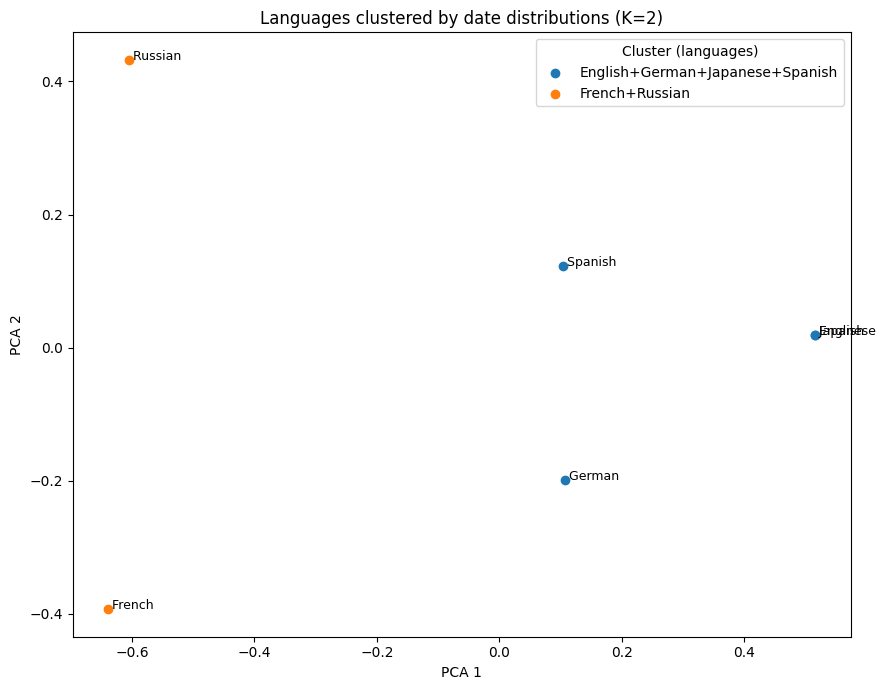

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ---------------------------
# 1) Pretend dataset (inline)
# ---------------------------
data = [
    # English: clustered around 1998-2006
    {"language": "English",  "date": "1998-05-01"},
    {"language": "English",  "date": "1999-07-14"},
    {"language": "English",  "date": "2001-03-10"},
    {"language": "English",  "date": "2002-08-22"},
    {"language": "English",  "date": "2004-11-02"},
    {"language": "English",  "date": "2006-01-18"},

    # French: around 1978-1992
    {"language": "French",   "date": "1978-04-04"},
    {"language": "French",   "date": "1980-05-01"},
    {"language": "French",   "date": "1981-06-17"},
    {"language": "French",   "date": "1988-09-30"},
    {"language": "French",   "date": "1992-12-12"},

    # Spanish: bimodal (2000s + 2015-2019)
    {"language": "Spanish",  "date": "2000-01-01"},
    {"language": "Spanish",  "date": "2001-02-02"},
    {"language": "Spanish",  "date": "2003-06-05"},
    {"language": "Spanish",  "date": "2015-03-02"},
    {"language": "Spanish",  "date": "2017-08-09"},
    {"language": "Spanish",  "date": "2019-11-05"},

    # Russian: older cluster 1949-1976
    {"language": "Russian",  "date": "1949-01-01"},
    {"language": "Russian",  "date": "1950-04-04"},
    {"language": "Russian",  "date": "1951-07-07"},
    {"language": "Russian",  "date": "1963-05-20"},
    {"language": "Russian",  "date": "1976-12-12"},

    # Japanese: similar to English (2000-2005)
    {"language": "Japanese", "date": "2000-10-10"},
    {"language": "Japanese", "date": "2001-10-10"},
    {"language": "Japanese", "date": "2002-11-11"},
    {"language": "Japanese", "date": "2003-12-12"},
    {"language": "Japanese", "date": "2005-02-14"},

    # German: spread 1985-2005
    {"language": "German",   "date": "1985-01-01"},
    {"language": "German",   "date": "1990-06-15"},
    {"language": "German",   "date": "1998-07-22"},
    {"language": "German",   "date": "2001-09-09"},
    {"language": "German",   "date": "2005-12-31"},
]

df = pd.DataFrame(data)

# -------------------------------------------
# 2) Parse dates -> extract YEAR as an integer
# -------------------------------------------
def to_year(val):
    dt = pd.to_datetime(val, errors="coerce")
    return None if pd.isna(dt) else dt.year

df["_year"] = df["date"].apply(to_year)
df = df.dropna(subset=["_year"]).copy()
df["_year"] = df["_year"].astype(int)

# --------------------------------------------------------------------
# 3) Build per-language normalized histograms over global year bins
# --------------------------------------------------------------------
all_years = df["_year"].to_numpy()
bin_edges = np.histogram_bin_edges(all_years, bins="auto")
if len(bin_edges) < 3:
    bin_edges = np.linspace(all_years.min(), all_years.max(), num=3)

X = []          # feature vectors (normalized histograms)
languages = []  # language names
counts = []     # #rows per language

for lang, sub in df.groupby("language"):
    years = sub["_year"].to_numpy()
    hist, _ = np.histogram(years, bins=bin_edges)
    hist = hist.astype(float)
    if hist.sum() == 0:
        continue
    hist /= hist.sum()  # normalize to probability distribution
    X.append(hist)
    languages.append(lang)
    counts.append(len(sub))

X = np.array(X)
if len(languages) < 2:
    raise SystemExit("Need at least two languages with valid dates for clustering.")

# -------------------------------------
# 4) Choose K via silhouette (optional)
# -------------------------------------
def choose_k_via_silhouette(X, k_min=2, k_max=10, random_state=42):
    k_max = min(k_max, X.shape[0] - 1)  # k < n_samples
    best_k, best_score = None, -1.0
    for k in range(k_min, max(k_min, k_max) + 1):
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        if len(set(labels)) in (1, len(labels)):
            continue
        score = silhouette_score(X, labels, metric="euclidean")
        if score > best_score:
            best_k, best_score = k, score
    return best_k if best_k is not None else 1

FORCE_K = None  # set to an int (e.g., 3) to force K; leave None to auto-pick
if FORCE_K is None:
    k = choose_k_via_silhouette(X, k_min=2, k_max=10, random_state=42)
    if k == 1 and X.shape[0] > 1:
        k = 2
else:
    k = max(1, min(FORCE_K, X.shape[0]))

# --------------------------
# 5) Fit KMeans & name groups
# --------------------------
km = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_ids = km.fit_predict(X)

# Build human-readable cluster names by joining languages in each cluster
cluster_to_langs = {}
for lang, cid in zip(languages, cluster_ids):
    cluster_to_langs.setdefault(cid, []).append(lang)

# Sort language names within each cluster for stable names
for cid in cluster_to_langs:
    cluster_to_langs[cid] = "+".join(sorted(cluster_to_langs[cid]))

# Map numeric cluster -> name
cluster_names = [cluster_to_langs[cid] for cid in cluster_ids]

# Final table
out = (
    pd.DataFrame({
        "language": languages,
        "n_mentions": counts,
        "cluster_id": cluster_ids,
        "cluster_name": cluster_names
    })
    .sort_values(["cluster_name", "language"])
    .reset_index(drop=True)
)

print(f"\nChosen K = {k}")
print("Languages clustered by similarity of date distributions (named by member languages):\n")
print(out.to_string(index=False))

# ----------------------------------------
# 6) Optional: quick 2D PCA visualization
# ----------------------------------------
if X.shape[0] >= 2 and X.shape[1] >= 2:
    pca = PCA(n_components=2, random_state=42)
    emb2 = pca.fit_transform(X)

    plt.figure(figsize=(9, 7))
    # plot points by cluster name
    for cname in sorted(set(cluster_names)):
        idx = [i for i, n in enumerate(cluster_names) if n == cname]
        plt.scatter(emb2[idx, 0], emb2[idx, 1], label=cname)
    for (x, y), lang in zip(emb2, languages):
        plt.text(x, y, f" {lang}", fontsize=9)
    plt.title(f"Languages clustered by date distributions (K={k})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="Cluster (languages)")
    plt.tight_layout()
    plt.show()
